In [ ]:
grid_params_dtr = {'max_depth': range(5,30,5),
               'min_samples_split': range(25,35,2),
              'max_leaf_nodes': range(10,100,10)}
#                'max_features': [2,4,6,8,10],

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}
# 'bootstrap': [True, False], 'max_features': [2,4,6,8,10]
# 'max_depth': range(5,30,5), 'min_samples_split': [2,4,8], 'min_samples_leaf': [2,4,6,8,10]

def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('###### BEST ', model.__class__.__name__, '#####')
    print(f'교차 검증별 RMSE:{np.round(rmse_scores, 4)}')
    print('5 교차 검증의 평균 RMSE: {0:.3f}\n'.format(avg_rmse))

    

def data_split(data):
    X_feature = data.drop(['gid_y'], axis=1)
    y_target = data['gid_y']
    
    return X, y
    
    
def model_dtr(X, y):
    dtr = DecisionTreeRegressor(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    grid_dtree = GridSearchCV(dtr, param_grid=grid_params_dtr, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, refit=True)
    grid_dtree.fit(X_train, y_train)
    
    scores_df_dtree = pd.DataFrame(grid_dtree.cv_results_)
    
    for mean_score, params, rank in zip(scores_df_dtree['mean_test_score'], scores_df_dtree['params'], scores_df_dtree['rank_test_score'].sort_values()[:5]):
        print(f'Top 5 파라미터: {np.sqrt(-1*mean_score), params, rank}\n')
    
    neg_mse_score = grid_dtree.best_score_
    rmse_score = np.sqrt(-1*neg_mse_score)

    
    print(f'\n최적 파라미터: {grid_dtree.best_params_}')
    print(f'최고 정확도: {np.round(rmse_score, 4)}\n')
    
    best_dtr = grid_dtree.best_estimator_
    y_train_pred = best_dtr.predict(X_train)
    y_test_pred = best_dtr.predict(X_test)
    
    print(f'train MSE: {np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 4)}')
    print(f'test MSE: {np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 4)}\n')
    
    get_model_cv_prediction(best_dtr, X_train, y_train)
    
    ftr_importances_values = best_dtr.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
    ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]
    plt.figure(figsize=(8,6))
    plt.title('Feature importances Top 5')
    sns.barplot(x=ftr_top5, y=ftr_top5.index)
    plt.show()
    
    
def model_rf(X, y):
    rf = RandomForestRegressor(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    grid_rf = GridSearchCV(rf, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, refit=True)
    grid_rf.fit(X_train, y_train)
    
    scores_df_rf = pd.DataFrame(grid_rf.cv_results_)
    
    #for mean_score, params, rank in zip(scores_df_rf['mean_test_score'], scores_df_rf['params'], scores_df_rf['rank_test_score'].sort_values()[:5]):
    #    print(f'Top 5 파라미터: {np.sqrt(-1*mean_score), params, rank}\n')
    
    neg_mse_score = grid_rf.best_score_
    rmse_score = np.sqrt(-1*neg_mse_score)

    
    print(f'\n최적 파라미터: {grid_rf.best_params_}')
    print(f'최고 정확도: {np.round(rmse_score, 4)}\n')
    
    best_rf = grid_rf.best_estimator_
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    print(f'train RMSE: {np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 4)}')
    print(f'test RMSE: {np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 4)}\n')

    get_model_cv_prediction(best_rf, X_train, y_train)
    
    ftr_importances_values = best_rf.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
    ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]
    plt.figure(figsize=(8,6))
    plt.title('Feature importances Top 5')
    sns.barplot(x=ftr_top5, y=ftr_top5.index)
    plt.show()

# asdfasdfsdf

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Random Forest (대수) (교통량 1, 전기차 2)

In [64]:
df_my = pd.read_excel('격자+교통량 데이터(k=1)+전기자동차 대수 데이터(k=2).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [266]:
rf_reg = RandomForestRegressor(random_state=0)

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_rf = GridSearchCV(estimator=rf_reg, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=inner_cv)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(f'rf boost: {(-1*gs_rf.best_score_).round(4)}')

scores_rf = cross_val_score(gs_rf, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_rf), np.std(-1*scores_rf)))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
XGB boost: 0.7602
CV mean squared error: 0.7854 +/- 0.237


In [65]:
import shap
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=1000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


print(np.round(r2_score(y_train, y_train_pred), 4))
print(np.round(r2_score(y_test, y_test_pred), 4))


shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

0.6062
0.3132


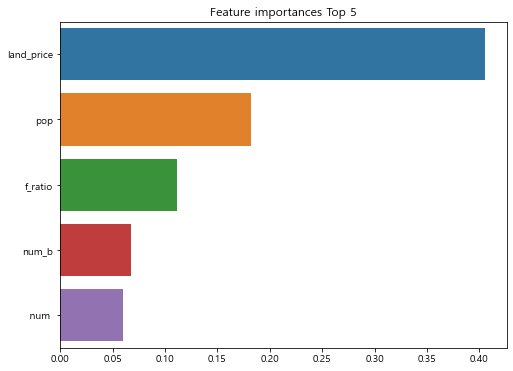

In [56]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

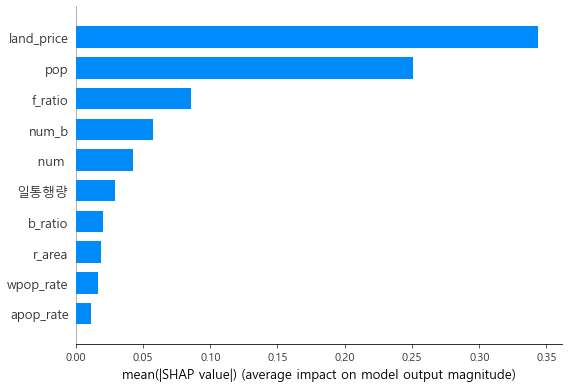

In [57]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


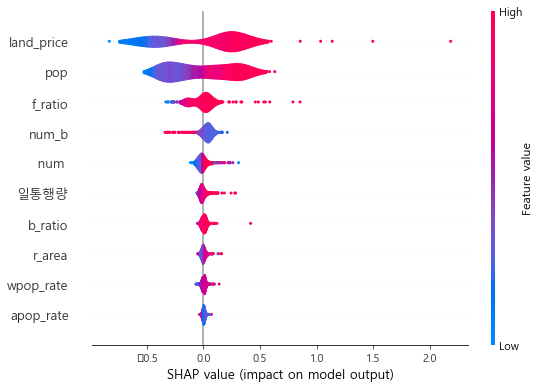

In [58]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# Random Forest (대수) (교통량 1, 전기차 3)

In [66]:
df_my = pd.read_excel('격자+교통량 데이터(k=1)+전기자동차 대수 데이터(k=3).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [269]:
rf_reg = RandomForestRegressor(random_state=0)

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_rf = GridSearchCV(estimator=rf_reg, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=inner_cv)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(f'rf boost: {(-1*gs_rf.best_score_).round(4)}')

scores_rf = cross_val_score(gs_rf, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_rf), np.std(-1*scores_rf)))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
XGB boost: 0.7398
CV mean squared error: 0.7833 +/- 0.228


In [67]:
import shap
from sklearn.metrics import mean_squared_error, r2_score



rf = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=500, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


print(np.round(r2_score(y_train, y_train_pred),4))
print(np.round(r2_score(y_test, y_test_pred),4))


shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

0.612
0.314


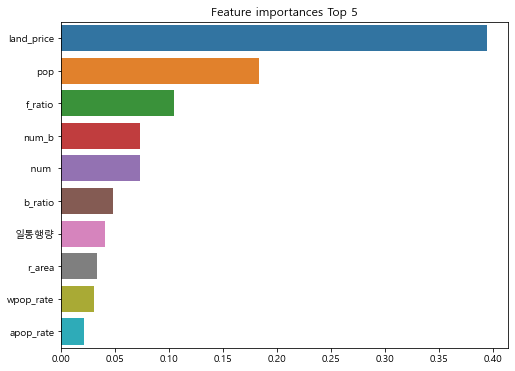

In [68]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)  # [:5]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

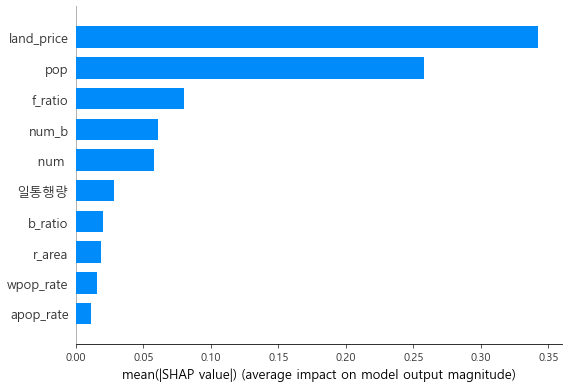

In [47]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


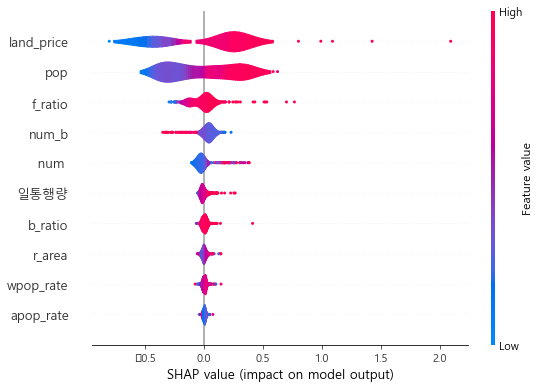

In [48]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# Random Forest (대수) (교통량 2, 전기차 2)

In [61]:
df_my = pd.read_excel('격자+교통량 데이터(k=2)+전기자동차 대수 데이터(k=2).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [33]:
rf_reg = RandomForestRegressor(random_state=0)

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_rf = GridSearchCV(estimator=rf_reg, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=inner_cv)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(f'rf boost: {(-1*gs_rf.best_score_).round(4)}')

scores_rf = cross_val_score(gs_rf, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_rf), np.std(-1*scores_rf)))

{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 1000}
rf boost: 0.9633
CV mean squared error: 1.0303 +/- 0.274


In [62]:
import shap
from sklearn.metrics import mean_squared_error, r2_score



rf = RandomForestRegressor(max_depth=8, min_samples_split=2, n_estimators=1000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


print(np.round(r2_score(y_train, y_train_pred),4))
print(np.round(r2_score(y_test, y_test_pred),4))


shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

0.8024
0.304


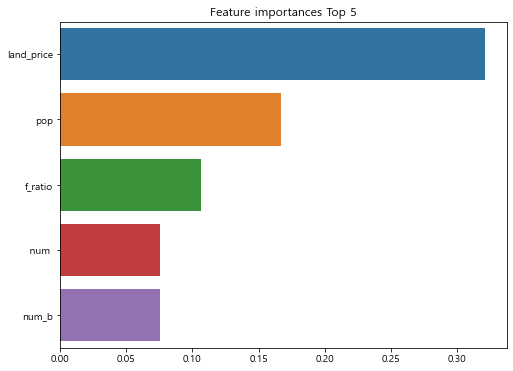

In [35]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

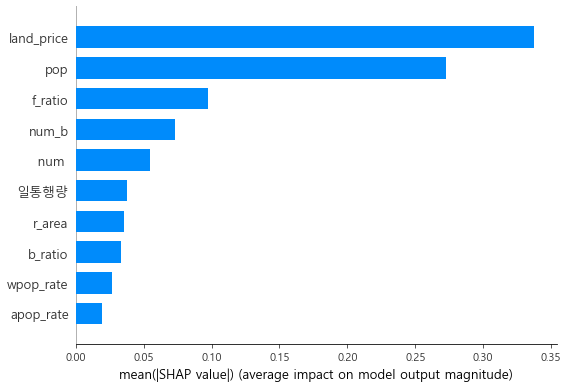

In [36]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


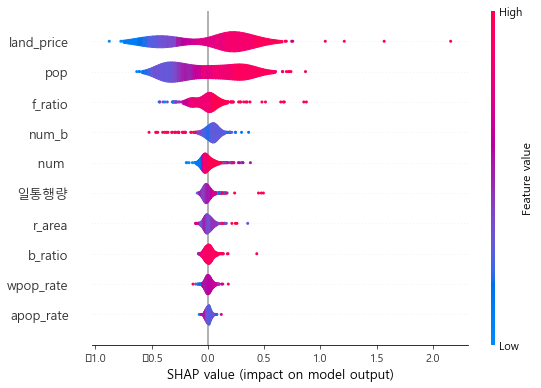

In [37]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# Random Forest (대수) (교통량 2, 전기차 3)

In [77]:
df_my = pd.read_excel('격자+교통량 데이터(k=2)+전기자동차 대수 데이터(k=3).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
rf_reg = RandomForestRegressor(random_state=0)

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_rf = GridSearchCV(estimator=rf_reg, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=inner_cv)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(f'rf score: {(-1*gs_rf.best_score_).round(4)}')

scores_rf = cross_val_score(gs_rf, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_rf), np.std(-1*scores_rf)))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
rf score: 0.9575
CV mean squared error: 1.0284 +/- 0.267


In [78]:
import shap
from sklearn.metrics import mean_squared_error, r2_score



rf = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=1000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


print(np.round(r2_score(y_train, y_train_pred),4))
print(np.round(r2_score(y_test, y_test_pred),4))


shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

0.6102
0.3029


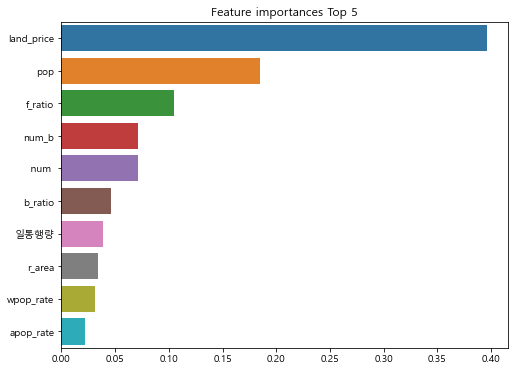

In [79]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top5 = ftr_importances.sort_values(ascending=False)   #[:5]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 5')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()

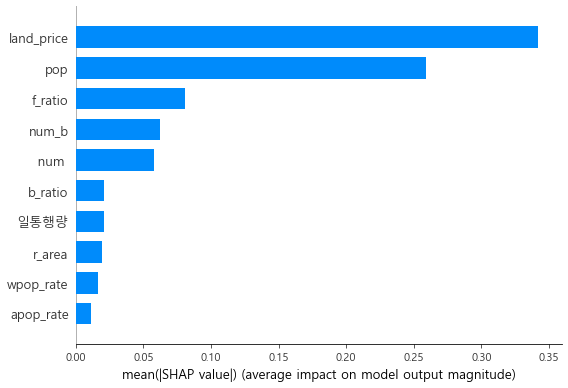

In [80]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


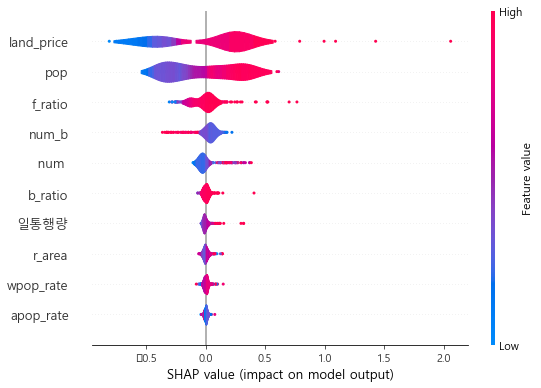

In [81]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

# Best K

## Random Forest (대수) (교통량 2, 전기차 3)

In [13]:
df_my = pd.read_excel('격자+교통량 데이터(k=2)+전기자동차 대수 데이터(k=3).xlsx')
df_my.drop(['Unnamed: 0'], axis=1 ,inplace=True)

X = df_my.drop(['gid_y'], axis=1)
y = df_my['gid_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
rf_reg = RandomForestRegressor(random_state=0)

grid_params_rf = {'n_estimators': [50, 200, 300, 500, 700, 1000],
                 'max_depth': range(5,30,3),
                 'min_samples_split': [2,4,8,10,12]}

inner_cv=KFold(n_splits=3, shuffle=True, random_state=0)
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0)

gs_rf = GridSearchCV(estimator=rf_reg, param_grid=grid_params_rf, scoring='neg_mean_squared_error', cv=inner_cv)
gs_rf.fit(X_train, y_train)

print(gs_rf.best_params_)
print(f'rf score: {(-1*gs_rf.best_score_).round(4)}')

scores_rf = cross_val_score(gs_rf, X, y, scoring='neg_mean_squared_error', cv=outer_cv)

print('CV mean squared error: %.4f +/- %.3f' % (np.mean(-1*scores_rf), np.std(-1*scores_rf)))

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}
rf score: 0.9575
CV mean squared error: 1.0284 +/- 0.267


In [14]:
import shap
from sklearn.metrics import mean_squared_error, r2_score



best_rf = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=1000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#from sklearn.preprocessing import StandardScaler 
#sc=StandardScaler()
#sc.fit(X_train)      
#X_train_std=sc.transform(X_train)    
#X_test_std=sc.transform(X_test)      


best_rf.fit(X_train, y_train)
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)


print(np.round(r2_score(y_train, y_train_pred),4))
print(np.round(r2_score(y_test, y_test_pred),4))


shap.initjs()
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

0.6102
0.3029


# test sample 예측

In [40]:
from sklearn.preprocessing import MinMaxScaler

class feature_score:
    # feature_dat = feature variable을 통한 scoring 결과로, scaler 전이며 (y, x, feature_variable)을 column으로 가지고 있는 dataframe.
    def __init__(self, feature_dat):
        self.feature_dat = feature_dat    
    # feature variable을 통한 score를 minmaxscaling 해주는 함수
    def feature_scaler(self, unscaled_score, min = 1, max = 10):
        scaler = MinMaxScaler(feature_range=(min, max))
        scaled_feature_score = scaler.fit_transform(unscaled_score.reshape(-1, 1))
        return pd.DataFrame(scaled_feature_score, columns=['feature_score'])
    # feature variable을 통한 scaled_scoring 결과
    def score(self, min = 1, max = 10):
        temp = self.feature_dat.copy()
        sample = temp.drop(temp.columns[[0,1]], axis = 1)
        cols = sample.columns.tolist()
        tmp = cols[0]
        del cols[0]
        cols.insert(7, tmp)
        sample = sample[cols]
        pred_sample = best_rf.predict(sample)
        scaled_pred_sample = self.feature_scaler(pred_sample, min, max)
        temp['feature_score'] = scaled_pred_sample
        return temp

In [41]:
feature_dat = pd.read_excel('sample_dat.xlsx')
feature_dat

,위도,경도,pop,wpop_rate,apop_rate,b_ratio,f_ratio,num_b,r_area,land_price,일통행량,num
0,37.479132,127.097849,3827.020187,0.667236,0.235777,39.182602,74.349468,201.143414,242.889409,1.297801e+06,34201.288933,52.975765
1,37.646592,127.046026,22238.353103,0.709059,0.212598,46.325230,179.649482,858.964844,120.452779,2.318498e+06,18292.392851,37.369624
2,37.521695,127.067788,4949.715990,0.713665,0.172667,32.342597,153.473467,201.871178,149.461725,5.039565e+06,56815.334307,88.778021
3,37.545310,127.186173,485.711019,0.708858,0.177355,5.726151,19.044918,16.561466,27.328600,2.664864e+05,49030.292609,111.341743
4,37.637137,127.068117,28813.838691,0.707949,0.208265,46.057104,149.616114,300.106125,133.760610,2.721819e+06,54123.720703,36.516347
5,37.584924,126.967558,4858.731907,0.700662,0.209440,48.277993,123.616187,822.665787,147.615023,2.031905e+06,13237.472693,59.063032
6,37.615603,126.997116,4149.508096,0.653778,0.291117,43.073741,80.158936,355.364025,84.396440,1.342113e+06,60007.518203,36.626255
7,37.628316,127.081170,19106.228638,0.734615,0.180134,43.626945,130.837018,712.249710,188.135294,2.419967e+06,29844.195620,61.048045
8,37.584854,127.000622,15977.441900,0.738433,0.198899,56.092353,168.696914,1972.044687,136.093661,3.856633e+06,19486.764813,24.786106
9,37.602030,126.970806,3788.623294,0.714075,0.204607,36.918601,84.320613,383.984761,148.178991,1.437731e+06,15388.621005,74.030204


In [42]:
feature_model = feature_score(feature_dat)
feature_model.score()

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- num
Feature names seen at fit time, yet now missing:
-  num 



,위도,경도,pop,wpop_rate,apop_rate,b_ratio,f_ratio,num_b,r_area,land_price,일통행량,num,feature_score
0,37.479132,127.097849,3827.020187,0.667236,0.235777,39.182602,74.349468,201.143414,242.889409,1.297801e+06,34201.288933,52.975765,1.600198
1,37.646592,127.046026,22238.353103,0.709059,0.212598,46.325230,179.649482,858.964844,120.452779,2.318498e+06,18292.392851,37.369624,8.818104
2,37.521695,127.067788,4949.715990,0.713665,0.172667,32.342597,153.473467,201.871178,149.461725,5.039565e+06,56815.334307,88.778021,1.794070
3,37.545310,127.186173,485.711019,0.708858,0.177355,5.726151,19.044918,16.561466,27.328600,2.664864e+05,49030.292609,111.341743,1.023922
4,37.637137,127.068117,28813.838691,0.707949,0.208265,46.057104,149.616114,300.106125,133.760610,2.721819e+06,54123.720703,36.516347,9.728306
5,37.584924,126.967558,4858.731907,0.700662,0.209440,48.277993,123.616187,822.665787,147.615023,2.031905e+06,13237.472693,59.063032,1.898770
6,37.615603,126.997116,4149.508096,0.653778,0.291117,43.073741,80.158936,355.364025,84.396440,1.342113e+06,60007.518203,36.626255,1.806551
7,37.628316,127.081170,19106.228638,0.734615,0.180134,43.626945,130.837018,712.249710,188.135294,2.419967e+06,29844.195620,61.048045,8.482720
8,37.584854,127.000622,15977.441900,0.738433,0.198899,56.092353,168.696914,1972.044687,136.093661,3.856633e+06,19486.764813,24.786106,7.859123
9,37.602030,126.970806,3788.623294,0.714075,0.204607,36.918601,84.320613,383.984761,148.178991,1.437731e+06,15388.621005,74.030204,1.580825
